# Context and Data Understanding 🎭

[Olist Store](https://olist.com/pt-br/)

- Source of Data: Brazilian ecommerce public dataset of orders - Olist Company

- Basics about Olist Company: Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

- Scope of Data: The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil.
- Dimension of Data: Order status, Price, payment and freight performance to customer location, product attributes and reviews ofcustomers

**Data Schema**

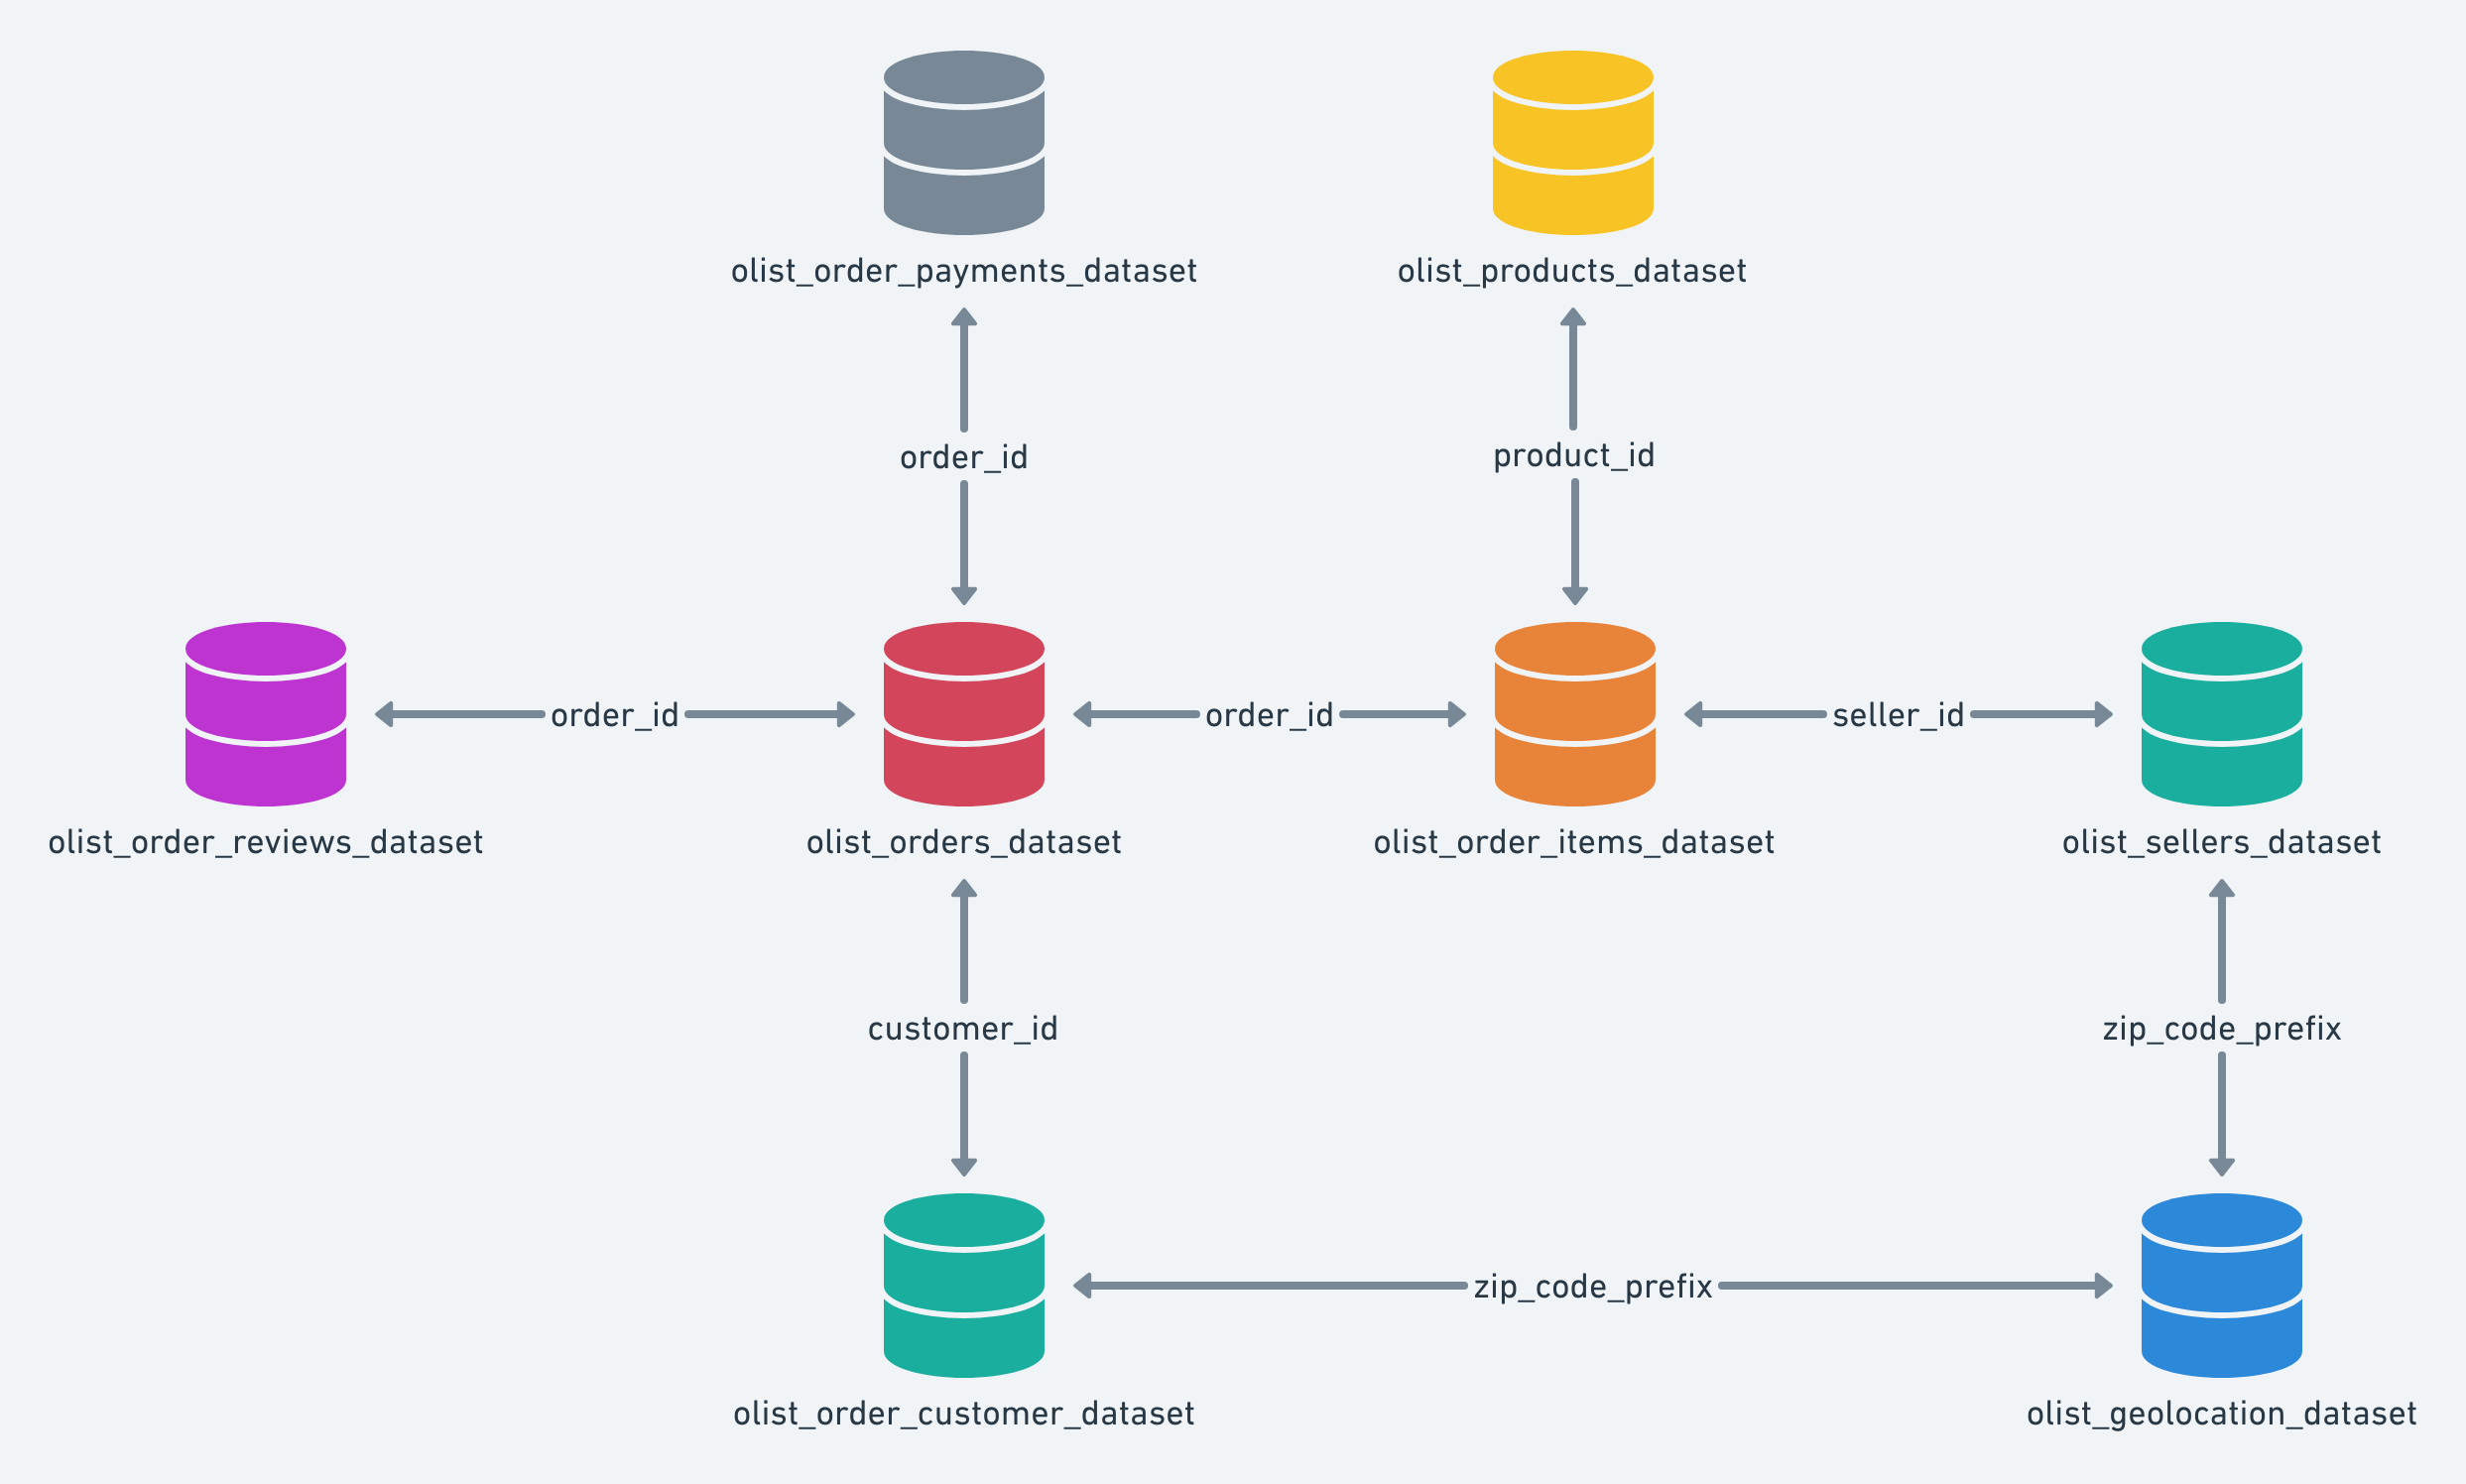

In [4]:
Image(filename = "C:\/Users/Win 10/Desktop/Data_Analytic_projects/Brazilian_E-Commerce_Company/Data Schema.png", width = 800, height = 200)

## Data Analytics (Basic EDA) 🔥

### Import Libraties 🎪

In [3]:
# Main Packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# For images
from IPython.display import Image
# In case we want to ignore the warning parts @-@
import warnings
warnings.filterwarnings("ignore")

### Import Datasets 🌸

In [1]:
import os
files = [f for f in os.listdir() if f.endswith(".csv")]
print(files)

['olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv']


In [5]:
# Customers, Sellers and Olist Geolocation 🍉
customer_data= pd.read_csv('olist_customers_dataset.csv')
seller_data= pd.read_csv('olist_sellers_dataset.csv')
geolocation_data= pd.read_csv('olist_geolocation_dataset.csv')

# Product 🥑
product_data= pd.read_csv('olist_products_dataset.csv')
# we discard the translation for product

# Order 🍒
order_data= pd.read_csv('olist_orders_dataset.csv')
order_item_data= pd.read_csv('olist_order_items_dataset.csv')
order_payment_data= pd.read_csv('olist_order_payments_dataset.csv')
order_review_data= pd.read_csv('olist_order_reviews_dataset.csv')

|Data name|Shape|Primary key|Foreign key|Columns|Remarks|
|:---|:---|:---|:---|:---|:---|
|Customer Data|(99441, 5)|customer_id||[customer_unique_id,customer_zip_code,customer_city,customer_state]||
|Seller Data|(3095, 4)|seller_id||[seller_zip_code,seller_city,seller_state]||
|Geolocation Data|(1000163, 5)|||[geolocation_lat,geolocation_long,geolocation_city,geolocation_state]||
|Product Data|(32951, 9)|product_id||[product_category_name,product_name_length,product_description_length,product_photo_quality,product_weight,product_length,product_width,product_hight]||
|Order Data|(99441, 8)|order_id|customer_id|[order_status,order_purchase_time,order_delivered_carrier_time,order_delivered_customer_time,order_predicted_delivered_time]||
|Order Item Data|(112650, 7)|order_id|[product_id,seller_id]|[shipping_limit_date,price,freight_value]||
|Order Payment Data|(103886, 5)|||[payment_sequential,payment_type,payment_installments,payment_value]||
|Order Review Data|(99224, 7)|||[review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_date]||

### Remove Duplicate Rows and Unnecessary Columns 🪐

In [17]:
customer_data.drop_duplicates(inplace=True)
seller_data.drop_duplicates(inplace=True)
geolocation_data.drop_duplicates(inplace=True)
product_data.drop_duplicates(inplace=True)
order_data.drop_duplicates(inplace=True)
order_item_data.drop_duplicates(inplace=True)
order_payment_data.drop_duplicates(inplace=True)
order_review_data.drop_duplicates(inplace=True)

In [18]:
# There are some columns that I deem unnecessary 🌝
order_payment_data.drop(['payment_sequential','payment_installments'], axis=1, inplace=True)
order_review_data.drop(['review_comment_title','review_creation_date','review_answer_timestamp'], axis=1,inplace=True)

In [19]:
geolocation_data.columns=['geolocation_zip_code', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state']

In [363]:
order_item_data.rename(columns={'order_item_id':'quantity'}, inplace=True)

In [364]:
order_item_data= order_item_data.assign(sale= lambda x: x['quantity']*x['price'])

## ASK QUESTIONS TO MAKE DATA-DRIVEN DECISIONS 🌞

### Which Product categories should Olist focus on ? 🦔

- [**About Review rating and Number of Review Message**] 🌲

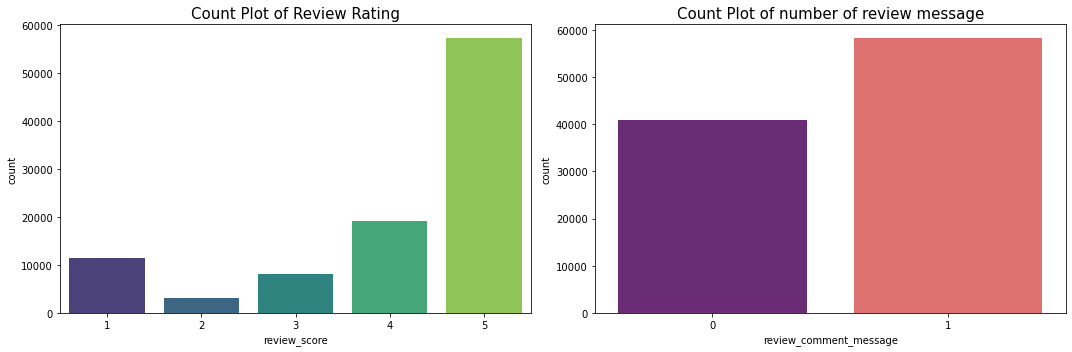

In [161]:
# Count plot for review_score 🍁
fig, ax= plt.subplots(ncols=2,figsize=(15,5))
sns.countplot(x='review_score', data=order_review_data, palette='viridis', ax=ax[0])
ax[0].set_title('Count Plot of Review Rating', fontsize=15)
sns.countplot(x='review_comment_message', palette='magma', ax=ax[1],
              data=pd.DataFrame(order_review_data['review_comment_message'].isna()).astype(int))
ax[1].set_title('Count Plot of number of review message', fontsize=15)
fig.tight_layout();

In [201]:
display((order_review_data['review_score'].isin([4,5])).sum(), # number of high review
(order_review_data['review_comment_message'].isna()).sum()) # number of no comment

76470

58247

Interpretation: 
- In general, all the orders have high review ratings, with over 77% of high ratings (4,5)
- Over half of customer don't leave comments (around 58.7%)

- [**Average Rating and Number of Review by Product categories**] 🐚

In [254]:
# We aim to calculate the mean rating of all product categories 🐲
# we merge 3 df(s): review + order_item + product 🌝
rating_product= pd.merge(order_review_data, order_item_data[['order_id','product_id']]
         , on='order_id').merge(product_data[['product_id','product_category_name']], on='product_id')
rating_product['num review']= rating_product['review_comment_message'].notna().astype(int)
rating_product.head(2)

,review_id,order_id,review_score,review_comment_message,product_id,product_category_name,num review
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,fd25ab760bfbba13c198fa3b4f1a0cd3,esporte_lazer,0
1,e2655da8bccce2ddc2f43cc2c80d24f3,19721d59a9764437477eff0730b48665,5,NaN,fd25ab760bfbba13c198fa3b4f1a0cd3,esporte_lazer,0


In [261]:
rating_product.groupby(by='product_category_name').agg({'num review':['sum','mean']}).droplevel(0,axis=1)

,sum,mean
product_category_name,,
agro_industria_e_comercio,59,0.324176
alimentos,163,0.369615
alimentos_bebidas,75,0.331858
artes,84,0.426396
artes_e_artesanato,10,0.454545
...,...,...
sinalizacao_e_seguranca,57,0.416058
tablets_impressao_imagem,28,0.368421
telefonia,1847,0.443670


In [282]:
# Number and percentage of review
review_product= rating_product.groupby(by='product_category_name').agg({'num review':['sum','mean']}).droplevel(0,axis=1)
review_product.rename(columns={'sum':'num review','mean':'% review'}, inplace=True)
# Average rating score
mean_rating_product= rating_product.groupby(by='product_category_name')['review_score'].mean()
mean_rating_product= pd.DataFrame(mean_rating_product).sort_values('review_score', ascending=False)
display(review_product.sort_values('num review', ascending=False).head(5), 
        review_product.sort_values('% review', ascending=False).head(5),
        mean_rating_product.head(5))

,num review,% review
product_category_name,,
cama_mesa_banho,4260,0.456200
beleza_saude,3346,0.380487
esporte_lazer,2949,0.383535
informatica_acessorios,2716,0.406648
moveis_decoracao,2543,0.401041


,num review,% review
product_category_name,,
seguros_e_servicos,2,1.000000
portateis_cozinha_e_preparadores_de_alimentos,9,0.642857
fashion_roupa_feminina,23,0.575000
fashion_roupa_masculina,63,0.572727
casa_conforto,199,0.542234


,review_score
product_category_name,
cds_dvds_musicais,4.666667
flores,4.538462
livros_interesse_geral,4.462451
livros_tecnicos,4.425781
construcao_ferramentas_ferramentas,4.425532


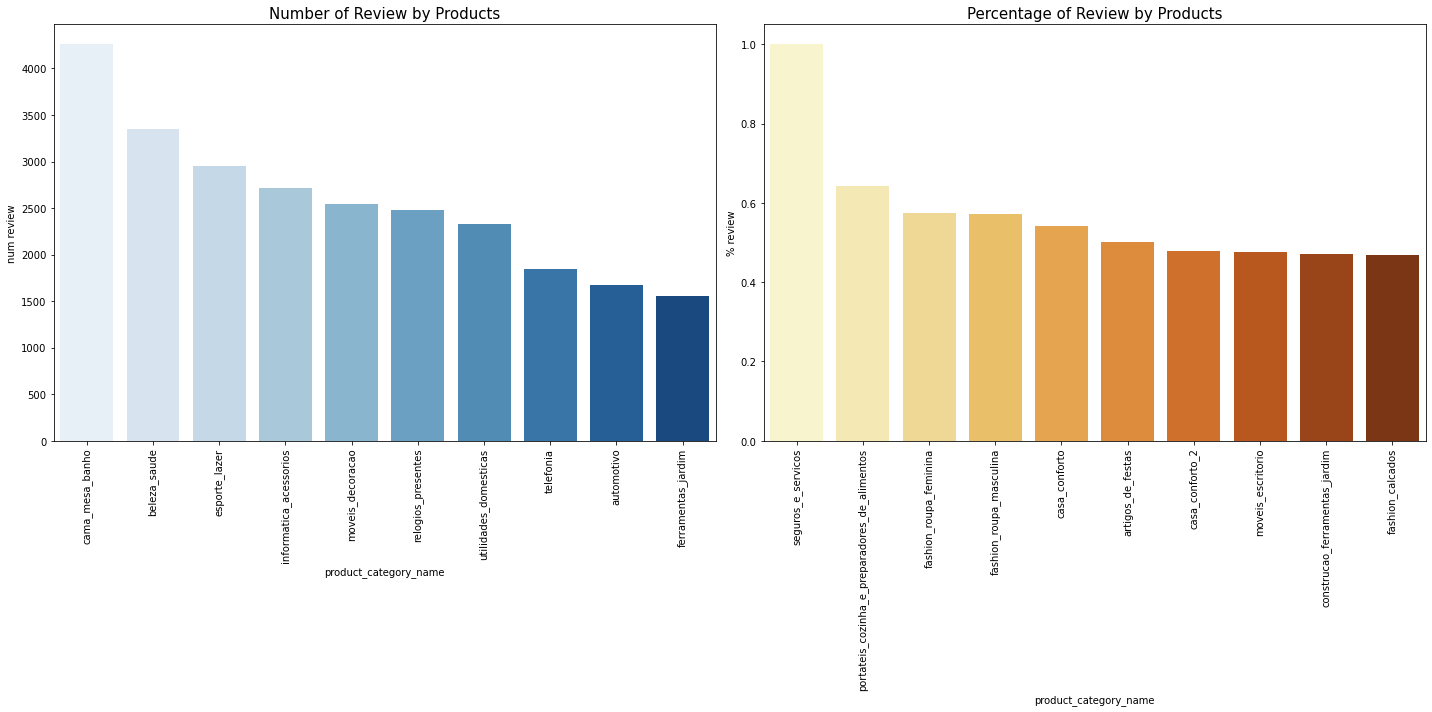

In [280]:
fig, ax= plt.subplots(ncols=2, figsize=(20,10))
sns.barplot(x='product_category_name',y='num review', palette='Blues',
           data=review_product.reset_index().sort_values('num review', ascending=False).head(10), ax=ax[0])
sns.barplot(x='product_category_name',y='% review',palette="YlOrBr",
           data=review_product.reset_index().sort_values('% review', ascending=False).head(10), ax=ax[1])
ax[0].set_title('Number of Review by Products', fontsize=15)
ax[1].set_title('Percentage of Review by Products', fontsize=15)
ax[0].tick_params(axis='x', labelrotation=90)
ax[1].tick_params(axis='x', labelrotation=90)
fig.tight_layout();

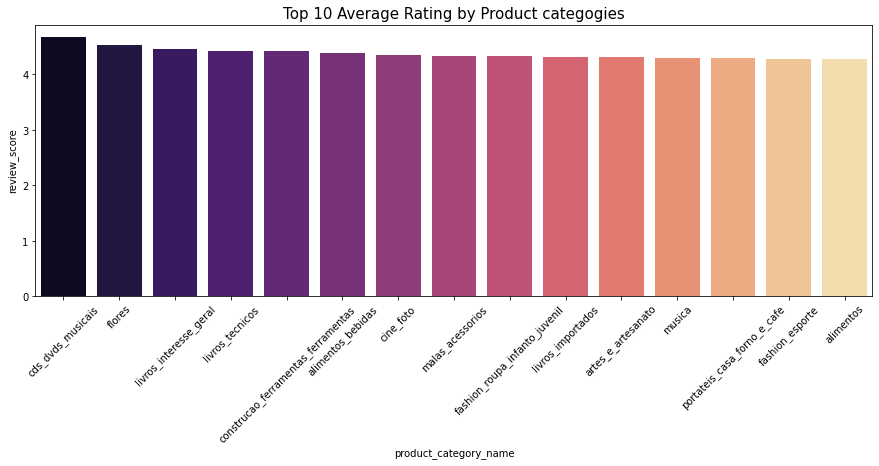

In [197]:
fig, ax= plt.subplots(figsize=(15,5))
sns.barplot(x='product_category_name',y='review_score', data=mean_rating_product.reset_index().head(15),
            palette='magma',ax=ax)
ax.set_title('Top 15 Average Rating by Product categogies', fontsize=15)
plt.xticks(rotation = 45);

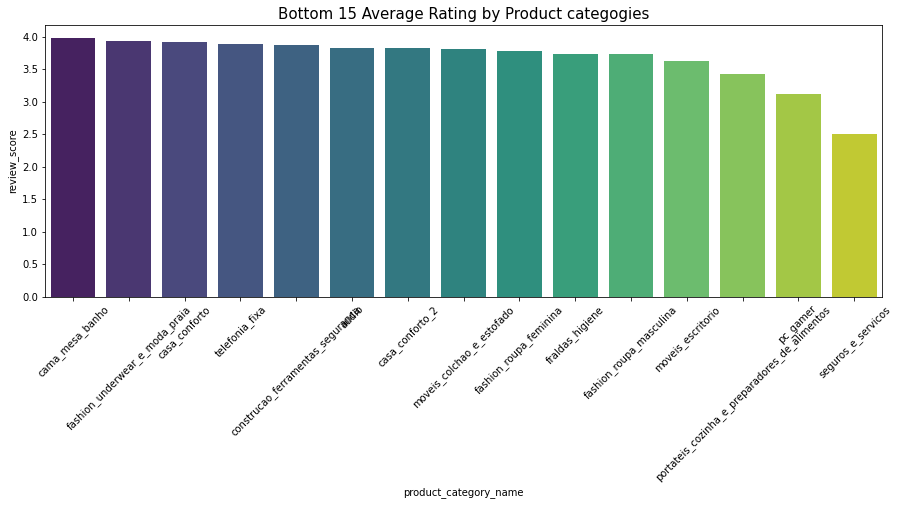

In [202]:
fig, ax= plt.subplots(figsize=(15,5))
sns.barplot(x='product_category_name',y='review_score', data=mean_rating_product.reset_index().tail(15),
            palette='viridis',ax=ax)
ax.set_title('Bottom 15 Average Rating by Product categogies', fontsize=15)
plt.xticks(rotation = 45);

Interpretation: 
- Overall, all product Categories have high and consistent average rating scores, with low rating is just roughly under 4/5
- The list of top 15 and bottom 15 product categories are shown above. 

- [**Number of orders, Quantity of sold units and Sale by Product categories**] 💐

In [28]:
# We aim to calculate total number of sold units by product categories 🍛
# We merge 2 df(s): order_item + product
quantity_sale_product= pd.merge(order_item_data[['quantity','product_id','price','order_id']],
                           product_data[['product_id','product_category_name']], on='product_id')

quantity_sale_product['sale']= quantity_sale_product['quantity']*quantity_sale_product['price']
quantity_sale_product.head(2)

,quantity,product_id,price,order_id,product_category_name,sale
0,1,4244733e06e7ecb4970a6e2683c13e61,58.9,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,58.9
1,1,4244733e06e7ecb4970a6e2683c13e61,55.9,130898c0987d1801452a8ed92a670612,cool_stuff,55.9


In [42]:
# Total number of Sale by products 🌭
order_product= quantity_sale_product.groupby(by='product_category_name')['order_id'].nunique()
order_product= pd.DataFrame(order_product).sort_values('order_id', ascending=False).rename(columns={'order_id':'num of order'})

# Total sold units by products 🍔
quantity_product= quantity_sale_product.groupby(by='product_category_name')['quantity'].sum()
quantity_product= pd.DataFrame(quantity_product).sort_values('quantity', ascending=False)
# Total sale by products 🍣
sale_product= quantity_sale_product.groupby(by='product_category_name')['sale'].sum()
sale_product= pd.DataFrame(sale_product).sort_values('sale', ascending=False)

display(order_product.head(5),quantity_product.head(5),sale_product.head(5))

,num of order
product_category_name,
cama_mesa_banho,9324
beleza_saude,8804
esporte_lazer,7688
informatica_acessorios,6666
moveis_decoracao,6334


,quantity
product_category_name,
cama_mesa_banho,11136
beleza_saude,9677
esporte_lazer,8650
moveis_decoracao,8297
informatica_acessorios,7832


,sale
product_category_name,
beleza_saude,1257970.83
relogios_presentes,1206520.90
cama_mesa_banho,1038954.92
esporte_lazer,986570.82
informatica_acessorios,911022.62


In [43]:
# We can find the list of all 'target' product categories that Olist should focus on 
# By finding the intersection of top categories in above 3 datasets 
n=30
target_products= list(set(order_product.head(n).index.tolist())&
                     set(quantity_product.head(n).index.tolist())&
                    set(sale_product.head(n).index.tolist()))
target_products[:5]
# len(target_products)=27

['ferramentas_jardim',
 'esporte_lazer',
 'consoles_games',
 'utilidades_domesticas',
 'relogios_presentes']

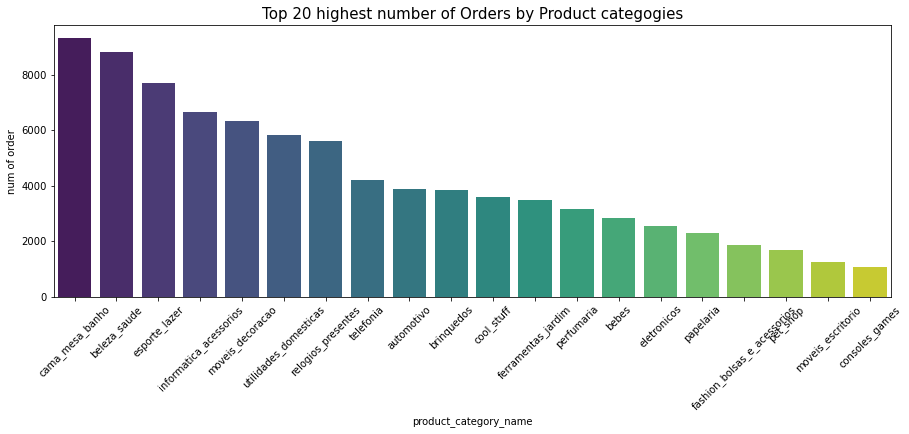

In [241]:
# Visualization for Num of orders by product categories 
fig, ax= plt.subplots(figsize=(15,5))
sns.barplot(x='product_category_name',y='num of order', data=order_product.reset_index().head(20),
            palette='viridis',ax=ax)
ax.set_title('Top 20 highest number of Orders by Product categogies', fontsize=15)
plt.xticks(rotation = 45);

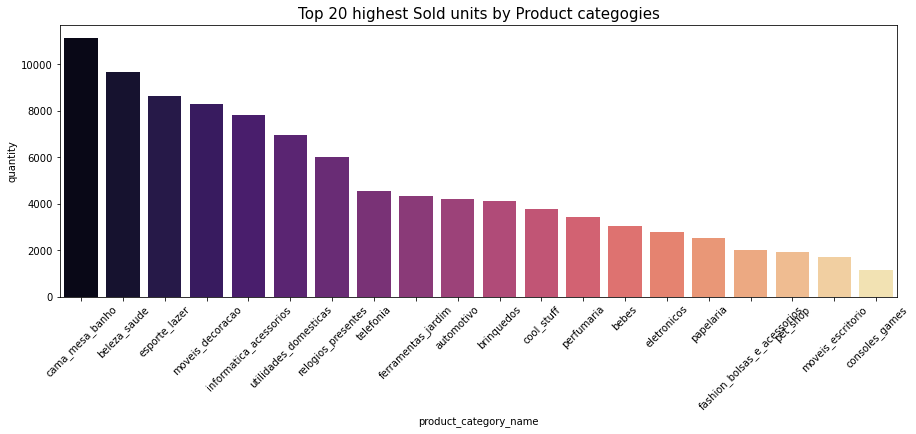

In [233]:
# Visualization for Num of sold units by product categories 
fig, ax= plt.subplots(figsize=(15,5))
sns.barplot(x='product_category_name',y='quantity', data=quantity_product.reset_index().head(20),
            palette='magma',ax=ax)
ax.set_title('Top 20 highest Sold units by Product categogies', fontsize=15)
plt.xticks(rotation = 45);

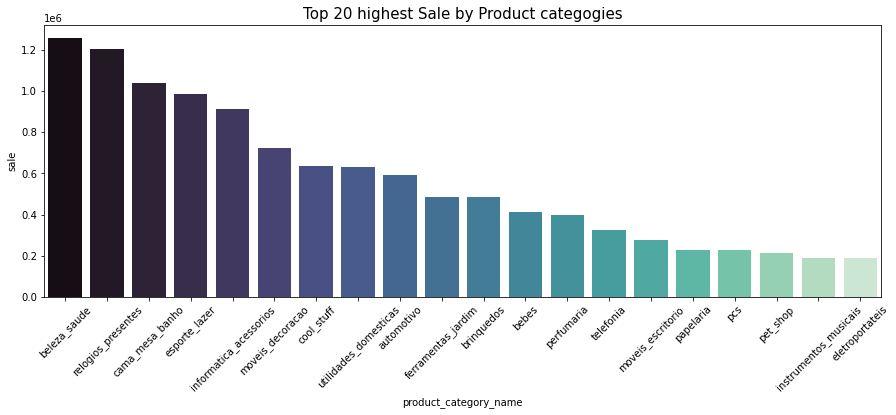

In [234]:
# Visualization for Num of sale by product categories 
fig, ax= plt.subplots(figsize=(15,5))
sns.barplot(x='product_category_name',y='sale', data=sale_product.reset_index().head(20),
            palette='mako',ax=ax)
ax.set_title('Top 20 highest Sale by Product categogies', fontsize=15)
plt.xticks(rotation = 45);

Interpretation:
- Visually, the num order, sale and sold quantity amongst product categories range a lot 
- Top 20 highest product categories in term of  num orders, sold units and sale are plotted above 
- The Target Products should be 'ferramentas_jardim',
 'esporte_lazer',
 'consoles_games',
 'utilidades_domesticas',
 'relogios_presentes',
 'instrumentos_musicais',
 'construcao_ferramentas_construcao',
 'bebes',
 'moveis_sala',
 'casa_construcao',
 'moveis_escritorio',
 'eletrodomesticos',
 'moveis_decoracao',
 'eletroportateis',
 'beleza_saude',
 'malas_acessorios',
 'informatica_acessorios',
 'cama_mesa_banho',
 'papelaria',
 'brinquedos',
 'cool_stuff',
 'eletronicos',
 'telefonia',
 'pet_shop',
 'automotivo',
 'fashion_bolsas_e_acessorios',
 'perfumaria'

### Which Factors may affect the Sale of the Products ? 🥇

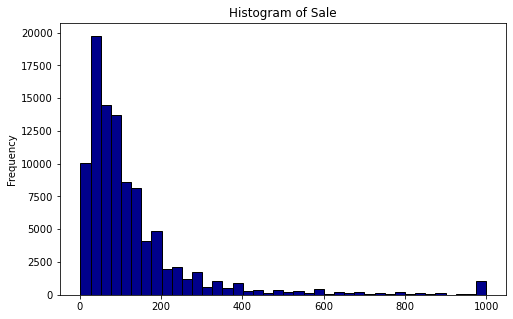

In [193]:
fig, ax= plt.subplots()
ax=order_item_data['sale'].clip(upper=1000).plot.hist(bins=40, color='darkblue', figsize=(8,5), edgecolor='black')
ax.set_title('Histogram of Sale');

In [54]:
product_data.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [75]:
# Total number of sale by products
total_sale_product= order_item_data.groupby('product_id',as_index=False)['sale'].sum()
total_sale_product.head(3)

,product_id,sale
0,00066f42aeeb9f3007548bb9d3f33c38,101.65
1,00088930e925c41fd95ebfe695fd2655,129.90
2,0009406fd7479715e4bef61dd91f2462,229.00


In [77]:
# We want to validate whether features of a product can affect its sale 🚀
# For eg: product_name_lenght, product_description_lenght,....
product_factor_sale= pd.merge(product_data,total_sale_product, on='product_id', validate='1:1')
product_factor_sale.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,sale
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,10.91
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,248.00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,79.80


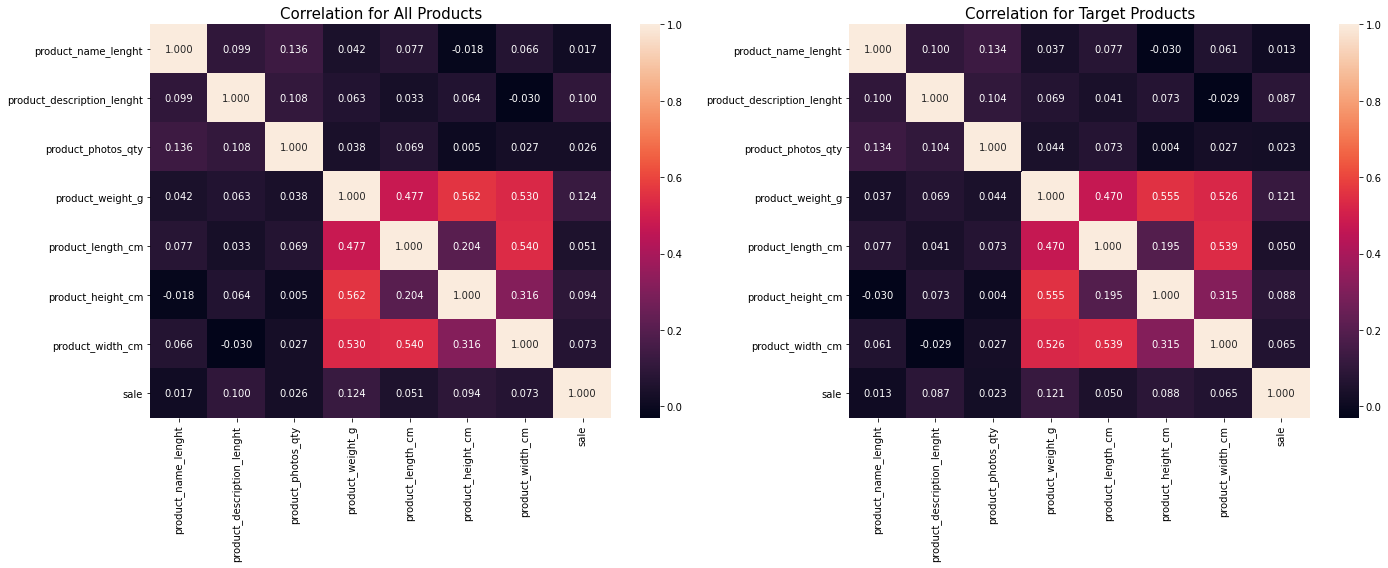

In [82]:
mask= product_factor_sale['product_category_name'].isin(target_products)
fig, ax= plt.subplots(ncols=2, figsize=(20,8))
sns.heatmap(product_factor_sale.corr(), annot=True, fmt='0.3f', ax=ax[0])
sns.heatmap(product_factor_sale[mask].corr(), annot=True, fmt='0.3f', ax=ax[1])
ax[0].set_title('Correlation for All Products', fontsize=15)
ax[1].set_title('Correlation for Target Products', fontsize=15)
fig.tight_layout();

In [87]:
product_factor_sale.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm', 'sale',
       'target_flag'],
      dtype='object')

In [84]:
product_factor_sale['target_flag']= mask.astype(int)

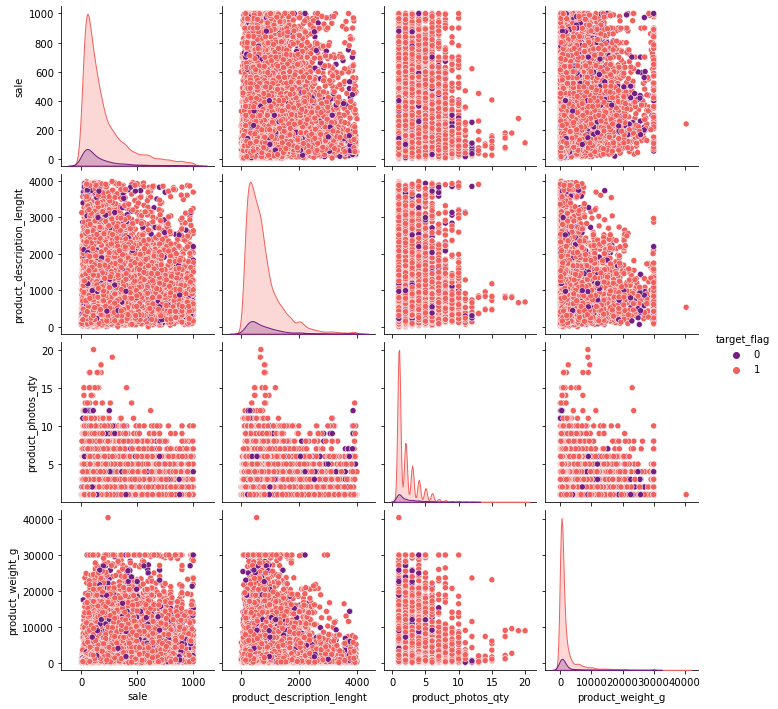

In [194]:
mask=product_factor_sale['sale']<1000
sns.pairplot(data=product_factor_sale[mask][['sale','target_flag','product_description_lenght',
                                      'product_photos_qty', 'product_weight_g']], hue='target_flag',
                                        size=2.5, palette='magma');

Interpretation:
- Clearly, there is no significant correlation between features of products and the amount of sale (low correlation magnitude and no clear patterns in scatter plots)

In [114]:
order_data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [116]:
# We can wonder whether the delivery time can affect the preference of customers
# We add 2 columns which is actual and estimated delivery days (in unit of day)
# actual delivery days= order_delivered_customer_date - order_purchase_timestamp
# estimated delivery days= order_estimated_delivery_date - order_purchase_timestamp
a= pd.to_datetime(order_data['order_purchase_timestamp'])
b= pd.to_datetime(order_data['order_delivered_customer_date'])
c= pd.to_datetime(order_data['order_estimated_delivery_date'])
order_data['actual_delivery_day']= (b-a).dt.days
order_data['estimated_delivery_day']= (c-a).dt.days
order_data.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_delivery_day,estimated_delivery_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8.0,15
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,13.0,19
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9.0,26


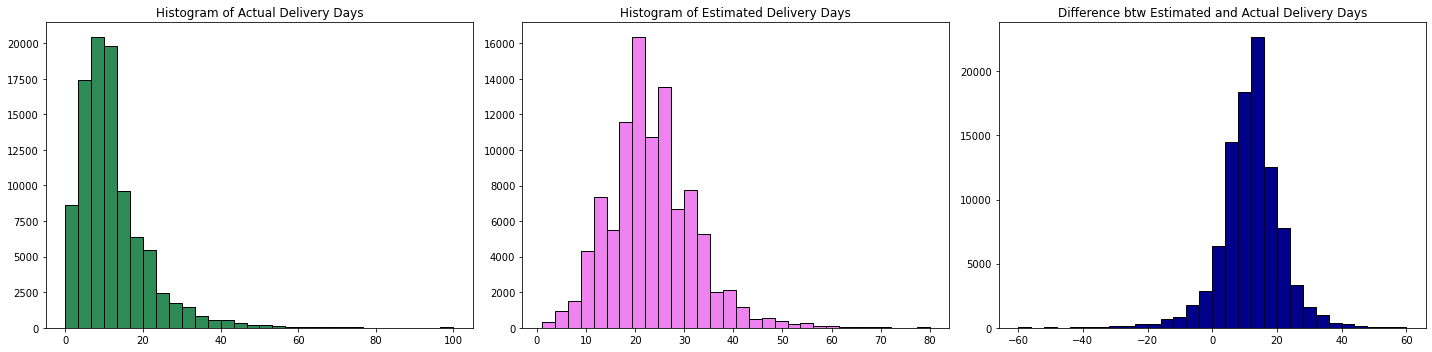

In [123]:
fig, ax= plt.subplots(ncols=3, figsize=(20,5))
ax[0].hist(order_data['actual_delivery_day'].clip(upper=100), bins=30, color='seagreen', edgecolor='black')
ax[1].hist(order_data['estimated_delivery_day'].clip(upper=80), bins=30, color='violet', edgecolor='black')
ax[2].hist((order_data['estimated_delivery_day']-order_data['actual_delivery_day']).clip(lower=-60, upper=60), 
           bins=30, color='darkblue', edgecolor='black')
ax[0].set_title('Histogram of Actual Delivery Days')
ax[1].set_title('Histogram of Estimated Delivery Days')
ax[2].set_title('Difference btw Estimated and Actual Delivery Days')
fig.tight_layout();

In [263]:
# Percentage of delivery before Estimated date 🧬
print((order_data['diff_delivery_day']>0).sum()/order_data.shape[0])
print('Delivery army did amazing jobs as most of the time they delivered on time 🎊')

0.8828149354893856
Delivery army did amazing jobs as most of the time they delivered on time 🎊


In [124]:
order_data['diff_delivery_day']= order_data['estimated_delivery_day']-order_data['actual_delivery_day']

In [126]:
order_item_data.head()

,order_id,quantity,product_id,seller_id,shipping_limit_date,price,freight_value,sale
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,239.90
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,199.90


In [132]:
delivery_sale= pd.merge(order_data[['order_id','actual_delivery_day','estimated_delivery_day','diff_delivery_day']],
        order_item_data[['order_id','product_id','sale']], on='order_id', validate='1:1')
delivery_sale.head(3)

,order_id,actual_delivery_day,estimated_delivery_day,diff_delivery_day,product_id,sale
0,e481f51cbdc54678b7cc49136f2d6af7,8.0,15,7.0,87285b34884572647811a353c7ac498a,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,13.0,19,6.0,595fac2a385ac33a80bd5114aec74eb8,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,9.0,26,17.0,aa4383b373c6aca5d8797843e5594415,159.90


In [133]:
delivery_sale.columns

Index(['order_id', 'actual_delivery_day', 'estimated_delivery_day',
       'diff_delivery_day', 'product_id', 'sale'],
      dtype='object')

In [140]:
df= delivery_sale.groupby('product_id').agg({'actual_delivery_day':'mean','estimated_delivery_day':'mean',
                                             'diff_delivery_day':'mean','sale':'sum'})
df.head(3)

,actual_delivery_day,estimated_delivery_day,diff_delivery_day,sale
product_id,,,,
00066f42aeeb9f3007548bb9d3f33c38,17.0,30.0,13.0,101.65
00088930e925c41fd95ebfe695fd2655,10.0,23.0,13.0,129.90
0009406fd7479715e4bef61dd91f2462,15.0,25.0,10.0,229.00


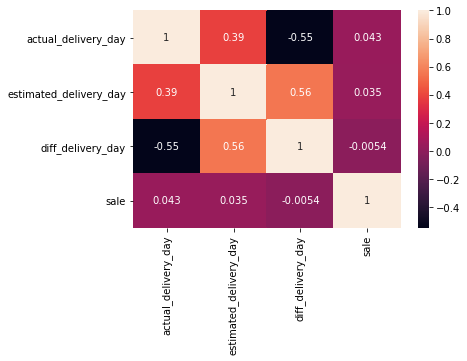

In [142]:
sns.heatmap(df.corr(), annot=True);

Interpretation:
- There is no significant relationship between Sales and numbers of delivery days 🌋

In [160]:
# I'm curious whether the review score affect the sale or not 🚀
review_score_sale=pd.merge(order_item_data[['order_id','product_id','sale']],order_review_data[['order_id','review_score']],
        on='order_id', validate='1:m')
review_score_sale.head(3)

,order_id,product_id,sale,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,5
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.9,4
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.0,5


In [164]:
review_score_sale_group= review_score_sale.groupby('product_id',as_index=False)[['review_score','sale']].mean()

In [181]:
labels= [f'{i} star' for i in np.arange(1,9)]
review_score_sale_group['sale range']= pd.qcut(review_score_sale['sale'],8,labels=labels)
review_score_sale_group= review_score_sale_group.groupby('sale range')['review_score'].mean().to_frame()
review_score_sale_group['review_score_increment']= review_score_sale_group['review_score']-4
review_score_sale_group

,review_score,review_score_increment
sale range,,
1 star,4.064713,0.064713
2 star,4.097417,0.097417
3 star,4.097999,0.097999
4 star,4.057194,0.057194
5 star,4.095094,0.095094
6 star,4.096056,0.096056
7 star,4.083585,0.083585
8 star,4.115842,0.115842


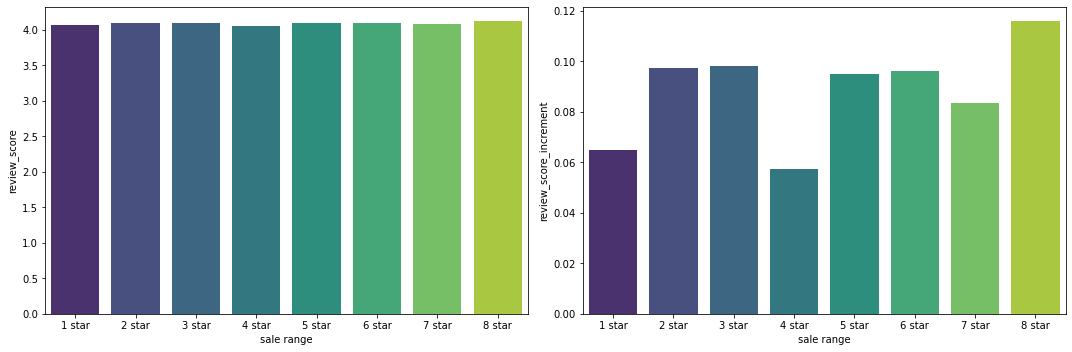

In [182]:
fig, ax= plt.subplots(ncols=2,figsize=(15,5))
sns.barplot(y='review_score',x='sale range',data=review_score_sale_group.reset_index(),
           palette='viridis', orient='v',ax=ax[0])
sns.barplot(y='review_score_increment',x='sale range',data=review_score_sale_group.reset_index(),
           palette='viridis', orient='v',ax=ax[1])
fig.tight_layout();

Interpretation: 
- We can see that there is no clear and significant impact of the review score to the sale, as almost all the products have roughly same score (around 4/5)
- The plot for incremental score partially shows that those products having highest review score tend to have high amount of sale. 

### About Customer Repurchase ? 🕌

In [211]:
customer_repurchase=customer_data[['customer_id','customer_unique_id']].groupby('customer_unique_id').count()
customer_repurchase.head(3)

,customer_id
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0000f46a3911fa3c0805444483337064,1


In [212]:
# Number of customers who repurchased at Olist ☎️
(customer_repurchase['customer_id']>1).sum()
# So percentage of repurchase = 3.12%

2997

In [229]:
customer_repurchase_count=customer_repurchase.value_counts().to_frame().reset_index()
customer_repurchase_count.columns= ['num of repurchase','count']
customer_repurchase_count.sort_values('num of repurchase')

,num of repurchase,count
0,1,93099
1,2,2745
2,3,203
3,4,30
4,5,8
5,6,6
6,7,3
8,9,1
7,17,1


Interpretation: 
- Most of customers dont repurchase at Olist (around 96.9%)

### Which States have highest number of Customers, Orders? 🌌

In [239]:
# Each customer has only 1 customer_unique_id, hence we count number of customers by state as below: 
state_customer= customer_data.groupby('customer_state')['customer_unique_id'].nunique().to_frame().sort_values('customer_unique_id', 
                                                                                               ascending=False)
state_customer.head()

,customer_unique_id
customer_state,
SP,40302
RJ,12384
MG,11259
RS,5277
PR,4882


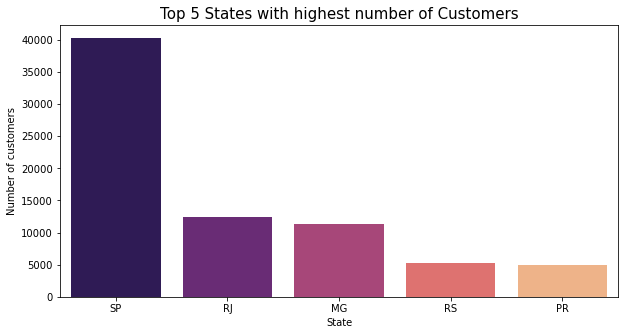

In [252]:
fig, ax= plt.subplots(figsize=(10,5))
sns.barplot(x='customer_state', y='customer_unique_id', 
            data=state_customer.reset_index().head(),palette='magma',ax=ax)
ax.set_title('Top 5 States with highest number of Customers', fontsize=15)
ax.set_xlabel('State')
ax.set_ylabel('Number of customers');

In [255]:
# Each customer_id represent for an order, hence we count number of orders by state as below: 
state_order= customer_data.groupby('customer_state',as_index=False)['customer_id'].count()
state_order.columns=['State','Number of Order']
state_order.sort_values('Number of Order',ascending=False, inplace=True)
state_order.head()

,State,Number of Order
25,SP,41746
18,RJ,12852
10,MG,11635
22,RS,5466
17,PR,5045


In [290]:
# We create a list to store top states 
target_customer_state= state_order['State'].head().tolist()
target_customer_state

['SP', 'RJ', 'MG', 'RS', 'PR']

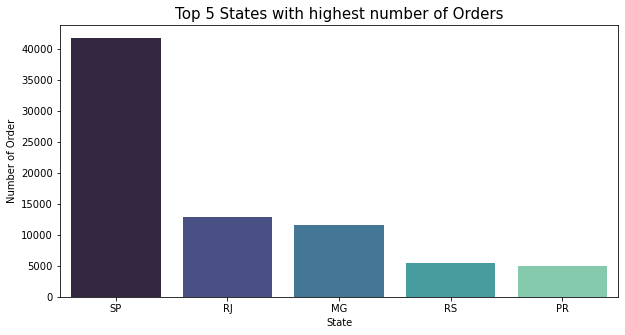

In [257]:
fig, ax= plt.subplots(figsize=(10,5))
sns.barplot(x='State', y='Number of Order', 
            data=state_order.head(),palette='mako',ax=ax)
ax.set_title('Top 5 States with highest number of Orders', fontsize=15);

Interpretation:
- Figures of top state in term of number of customers and orders are roughly similar
- Most of customers and orders are dominantly came from SP State 

### Which Cities have highest number of Orders ? 🎐

In [300]:
# We calculate number of orders by each city 🧸
city_order= customer_data.groupby('customer_city',as_index=False)['customer_id'].count().sort_values('customer_id',
                                                                                              ascending=False)
city_order.columns=['City','Number of Order']
city_order.head()

,City,Number of Order
3597,sao paulo,15540
3155,rio de janeiro,6882
453,belo horizonte,2773
558,brasilia,2131
1143,curitiba,1521


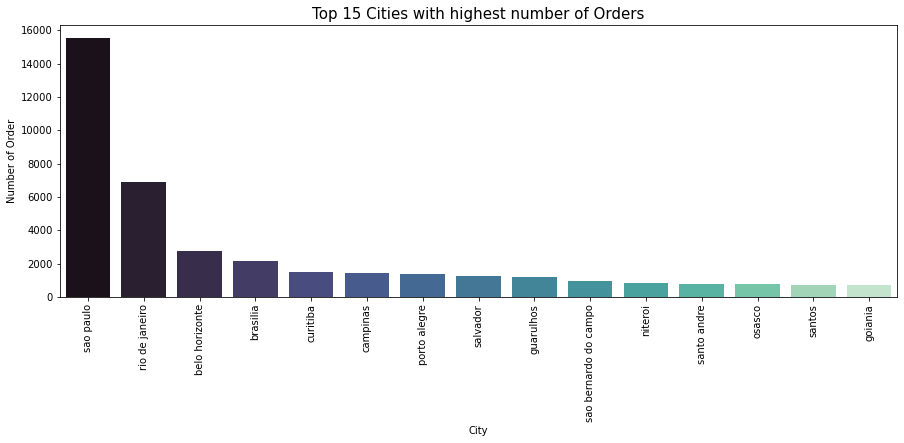

In [299]:
fig, ax= plt.subplots(figsize=(15,5))
sns.barplot(x='City', y='Number of Order', 
            data=city_order.head(15),palette='mako',ax=ax)
ax.set_title('Top 15 Cities with highest number of Orders', fontsize=15)
ax.tick_params(axis='x', labelrotation=90)

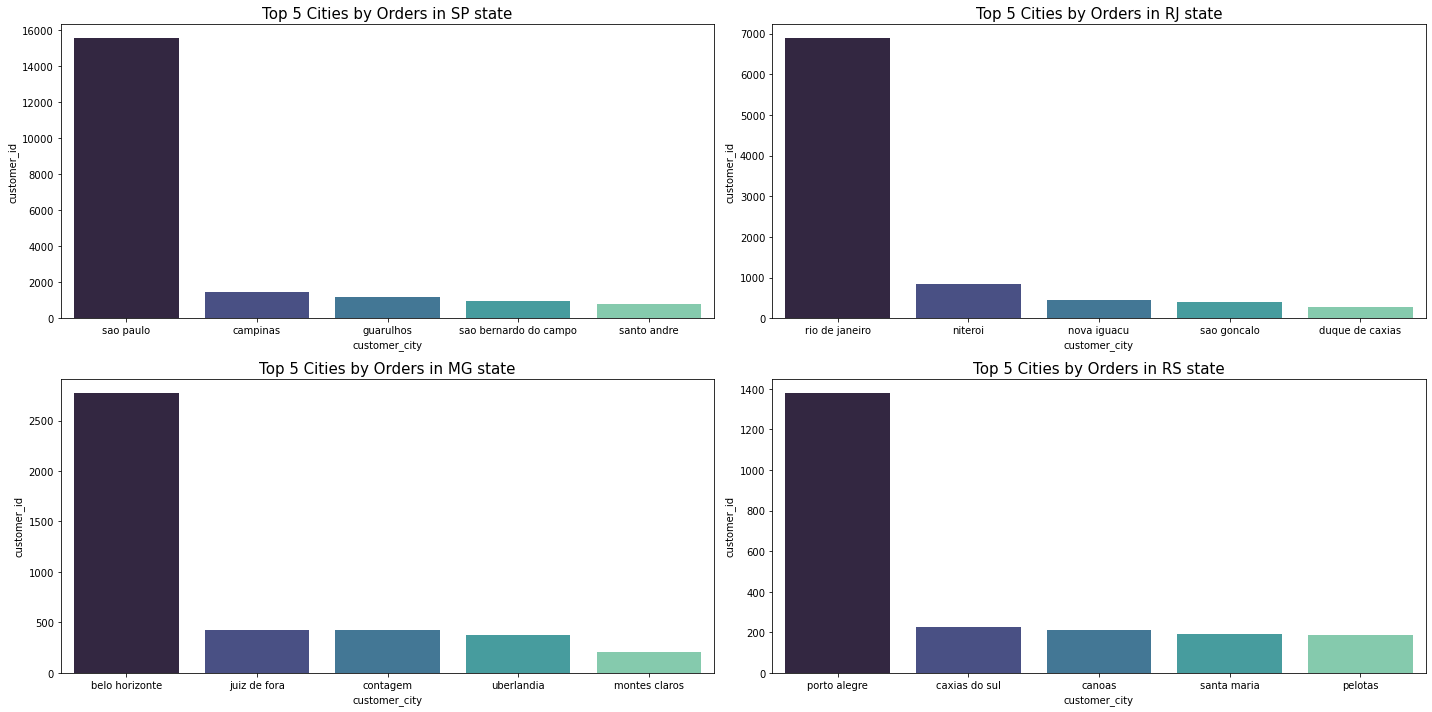

In [306]:
fig, ax= plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax_index=[ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
for i in range(4):
    mask=customer_data['customer_state']==target_customer_state[i]
    df=customer_data[mask].groupby('customer_city',as_index=False)['customer_id'].count().sort_values('customer_id',
                                                                                              ascending=False)
    sns.barplot(x='customer_city', y='customer_id', 
            data=df.head(),palette='mako',ax=ax_index[i])
    ax_index[i].set_title(f'Top 5 Cities by Orders in {target_customer_state[i]} state', fontsize=15)
fig.tight_layout();

Iterpretation:
- It can be seen that the high number of orders in each Target State is dominated by few Cities 
- For eg, for SP state is Sao Paulo, RJ state is Rio de Janerio,....

### Which States, Cities have highest number of Sellers ? 🎎

In [264]:
seller_data.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [272]:
# Number of sellers by states 🚦 
state_seller= seller_data.groupby('seller_state',as_index=False)['seller_id'].count().sort_values('seller_id',
                                                                                                  ascending=False)
state_seller.columns=['State','Number of Sellers']
state_seller.head()

,State,Number of Sellers
22,SP,1849
15,PR,349
8,MG,244
20,SC,190
16,RJ,171


In [308]:
city_seller= seller_data.groupby('seller_city',as_index=False)['seller_id'].count().sort_values('seller_id',
                                                                                                  ascending=False)
city_seller.columns=['City','Number of Sellers']
city_seller.head()

,City,Number of Sellers
517,sao paulo,694
159,curitiba,127
450,rio de janeiro,96
64,belo horizonte,68
442,ribeirao preto,52


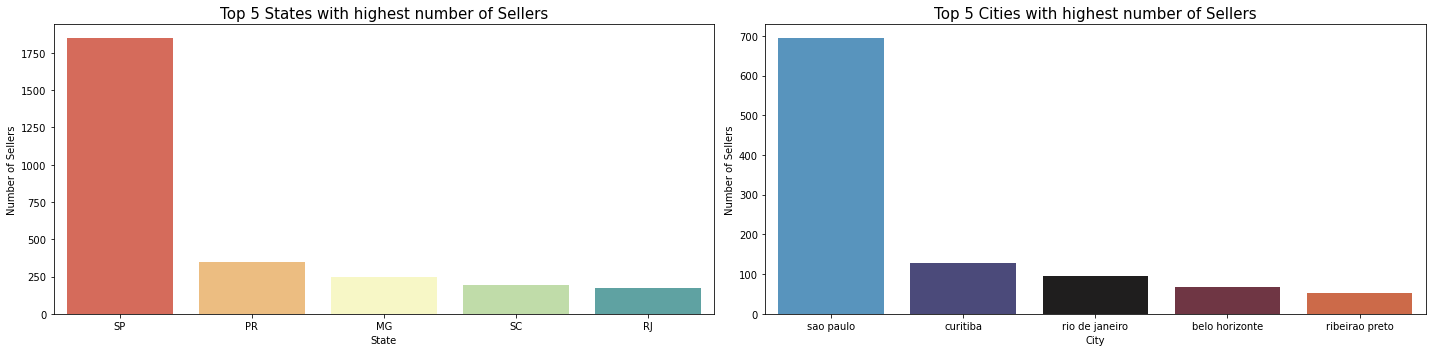

In [310]:
fig, ax= plt.subplots(ncols=2, figsize=(20,5))
sns.barplot(x='State', y='Number of Sellers', data=state_seller.head(), 
           palette="Spectral", ax=ax[0])
sns.barplot(x='City', y='Number of Sellers', data=city_seller.head(), 
           palette="icefire", ax=ax[1])
ax[0].set_title('Top 5 States with highest number of Sellers', fontsize=15)
ax[1].set_title('Top 5 Cities with highest number of Sellers', fontsize=15)
fig.tight_layout();

Interpretation: 
- In general, top state by number of sellers coincide with top state by customers amounts (except RS for customers and SC for sellers)
- Similarly for top cities in term of customers and sellers (except Brasilia for customers and Ribeirao Preto for sellers)

### About Payment types ? 🛸
- Just a few curiouslity into this dataset ^^

In [315]:
order_payment_data.head(3)

,order_id,payment_type,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,credit_card,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,credit_card,65.71


In [321]:
payment_type= order_payment_data.groupby('payment_type',as_index=False)['order_id'].count().sort_values('order_id',
                                                                                         ascending=False)
payment_type

,payment_type,order_id
1,credit_card,76795
0,boleto,19784
4,voucher,5775
2,debit_card,1529
3,not_defined,3


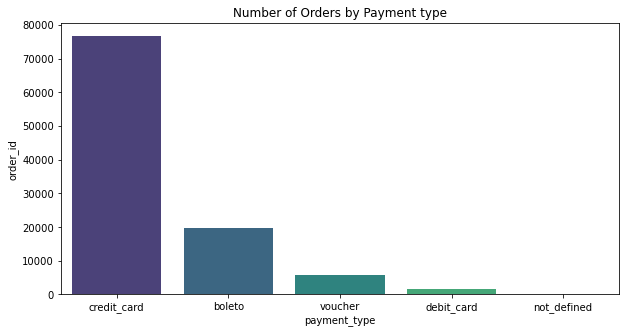

In [320]:
fig, ax= plt.subplots(figsize=(10,5))
sns.barplot(x='payment_type', y='order_id', data=payment_type, palette='viridis', ax=ax)
ax.set_title('Number of Orders by Payment type');

Interpretation: 
- Most of customers do the purchase by using Credit card 

### Total number of orders, quantity of sold items and sale over time ? 🌉

In [329]:
order_time= order_data[['order_id','order_purchase_timestamp']]
order_time['order_purchase_timestamp']= pd.to_datetime(order_time['order_purchase_timestamp']).dt.date
order_time.sort_values('order_purchase_timestamp', inplace=True)
order_time.head(3)

,order_id,order_purchase_timestamp
4541,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04
4396,e5fa5a7210941f7d56d0208e4e071d35,2016-09-05
10071,809a282bbd5dbcabb6f2f724fca862ec,2016-09-13


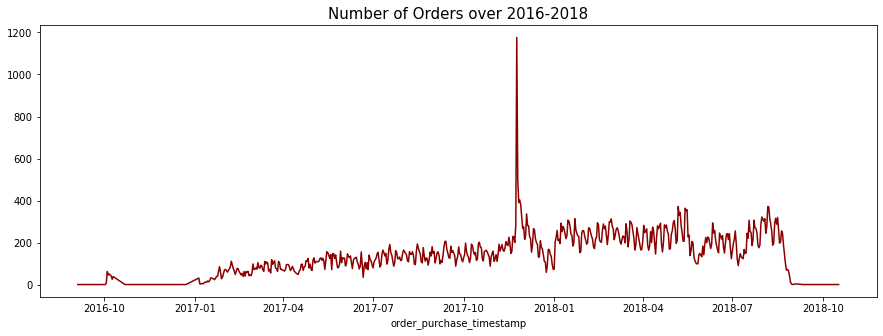

In [353]:
fig, ax= plt.subplots()
ax=order_time.groupby('order_purchase_timestamp')['order_id'].count().plot(figsize=(15,5), color='darkred')
ax.set_title('Number of Orders over 2016-2018', fontsize=15);

- Number of orders volatiled over the range 100-250 and Olist has an exceptional high number of orders in 2017-11-24

In [369]:
quantity_sale_time= pd.merge(order_time, order_item_data[['order_id','quantity','sale']] , on='order_id',
                            validate='1:m')
quantity_sale_time.head(3)

,order_id,order_purchase_timestamp,quantity,sale
0,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04,1,39.99
1,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04,2,65.80
2,e5fa5a7210941f7d56d0208e4e071d35,2016-09-05,1,59.50


In [370]:
quantity_sale_time= quantity_sale_time.groupby('order_purchase_timestamp',as_index=False)[['quantity','sale']].sum()
quantity_sale_time.head()

,order_purchase_timestamp,quantity,sale
0,2016-09-04,3,105.79
1,2016-09-05,1,59.50
2,2016-09-15,6,269.94
3,2016-10-02,1,100.00
4,2016-10-03,8,463.48


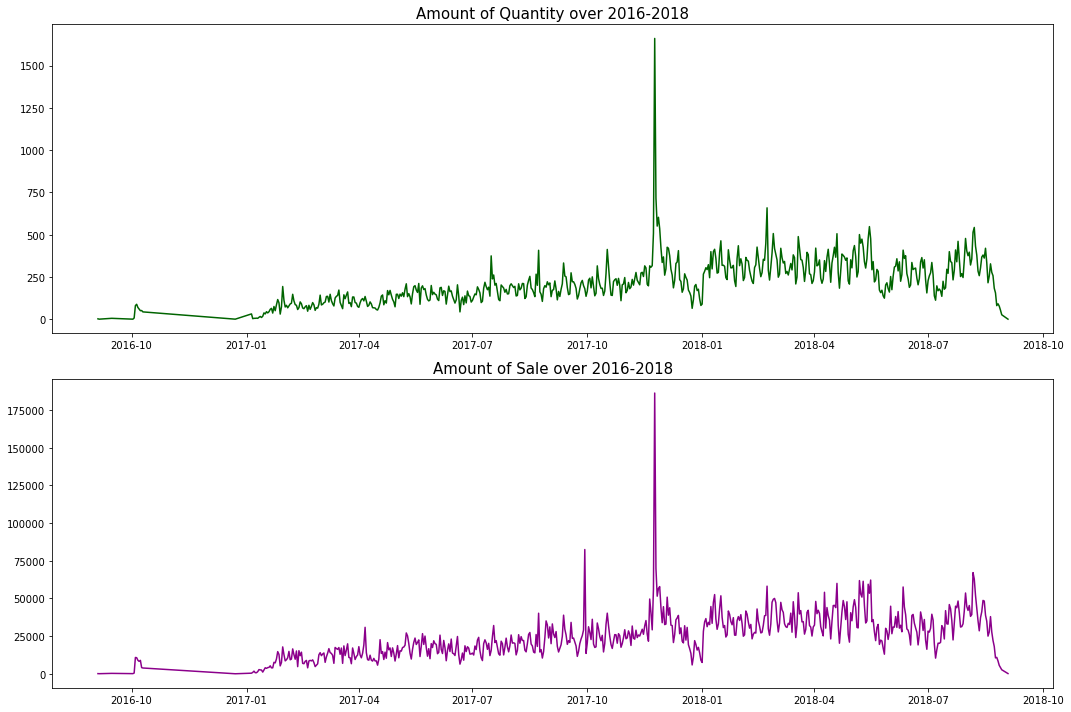

In [374]:
fig,ax= plt.subplots(nrows=2, figsize=(15,10))
ax[0].plot('order_purchase_timestamp', 'quantity',data=quantity_sale_time, color='darkgreen')
ax[1].plot('order_purchase_timestamp', 'sale', data=quantity_sale_time,color='darkmagenta')
ax[0].set_title('Amount of Quantity over 2016-2018', fontsize=15)
ax[1].set_title('Amount of Sale over 2016-2018', fontsize=15)
fig.tight_layout();